In [84]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import * 

from numpy import *

model bacteria resistance evolution

In [85]:
def make_sys(max_growth, carrying_capacity):
    newr = max_growth
    newk = carrying_capacity
    
    S = 89/90
    I = 1/90
    R = 0/90
    susceptible = 1
    resistant = 0.001
    reco_time = 4
   
    
    init = State(S=S, I=I, R=R, susceptible = susceptible, resistant= resistant, reco_time = reco_time )
    
    

    t_0 = 0
    t_end = 112
    dt = 1/24
    beta = 1/3
    base_tc = 4
    
    
    return System(init=init, r = newr, k = newk, beta = beta, base_tc = base_tc, t_0 = t_0, t_end=t_end, dt = dt)




In [86]:
def update_func_comb(state, t , system):
    newtc= system.base_tc * (1 + state.resistant)
    dsdt= -(system.beta * state.S * state.I) #+ (state.R *(1 + state.resistant))
    didt = (system.beta * state.S * state.I) - (state.I * (1/newtc))
    drdt = (state.I * (1/newtc)) #- (state.R * state.resistant)
    dbdt = system.r * state.resistant * (1 - (state.resistant/system.k))
    
    newS = state.S + (dsdt * system.dt)
    newI = state.I + (didt* system.dt)
    newR = state.R + (drdt* system.dt)
    newsusceptible = state.susceptible - (dbdt * system.dt)
    newresistant = state.resistant + (dbdt * system.dt)
    
    
    
    return State(S = newS, I = newI, R = newR, susceptible = newsusceptible, resistant = newresistant, reco_time = newtc )
    

In [87]:
def run_simulation_bact(state, system, update_func):
    frame = TimeFrame(columns = state.index)
    frame.row[system.t_0] = state
    
    for t in linrange(system.t_0,system.t_end,system.dt):
        frame.row[t+system.dt]=update_func(frame.row[t],t,system)
        
    return frame
    

In [88]:
def run_simulation(state, system, update_func):
    frame = TimeFrame(columns = system.init.index)
    frame.row[system.t_0] = system.init
    
    for t in linrange(system.t_0,system.t_end,system.dt):
        frame.row[t+system.dt]=update_func(frame.row[t],t,system)
        
    return frame


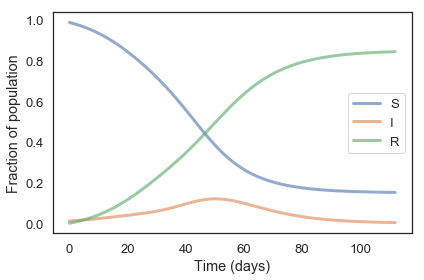

In [89]:
data = run_simulation(make_sys(0.2,1).init, make_sys(0.2,1), update_func_comb)
plot(data.index, data['S'], label = 'S')
plot(data.index, data['I'], label = 'I')
plot(data.index, data['R'], label = 'R')
#plot(data.index, data['susceptible'], label = 'susceptible')
#plot(data.index, data['resistant'], label = 'resistant')


decorate(xlabel='Time (days)',
         ylabel='Fraction of population')

Update Function

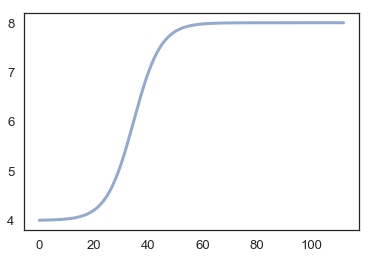

In [90]:
plot(data.index, data['reco_time'])

In [91]:
numpy.trapz(data['reco_time'], data.index)

NameError: name 'numpy' is not defined

Simulation

Metrics

Total infections(can exceed total popultion to represent re-infection)